# Laboratorio 3
### Data science - Lynette Garcia
Daniel Gomez 21429
Abner Garcia 21285

In [40]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

### Laboratorio anterior

In [41]:
# Cargar los datos
consuming = pd.read_csv('data/gas_consuming.csv', parse_dates=['Fecha'], index_col='Fecha', date_format='%b/%Y')
importation = pd.read_csv('data/gas_importation.csv', parse_dates=['Fecha'], index_col='Fecha', date_format='%b/%Y')

# Generar la columna 'Diesel' combinando 'Diesel bajo azufre' y 'Diesel ultra bajo azufre'
consuming['Diesel'] = consuming['Diesel bajo azufre'].fillna(0) + consuming['Diesel ultra bajo azufre'].fillna(0)
importation['Diesel'] = importation['Diesel bajo azufre'].fillna(0) + importation['Diesel ultra bajo azufre'].fillna(0)

# Primero, eliminamos cualquier carácter no numérico o espacios en blanco
consuming['Gasolina regular'] = consuming['Gasolina regular'].str.replace(',', '').str.strip()
consuming['Gasolina superior'] = consuming['Gasolina superior'].str.replace(',', '').str.strip()
consuming['Diesel'] = consuming['Diesel'].str.replace(',', '').str.strip()
consuming['Gas licuado de petróleo'] = consuming['Gas licuado de petróleo'].str.replace(',', '').str.strip()

importation['Gasolina regular'] = importation['Gasolina regular'].str.replace(',', '').str.strip()
importation['Gasolina superior'] = importation['Gasolina superior'].str.replace(',', '').str.strip()
importation['Diesel'] = importation['Diesel'].str.replace(',', '').str.strip()
importation['Gas licuado de petróleo'] = importation['Gas licuado de petróleo'].str.replace(',', '').str.strip()

# Luego, convertimos las columnas a float
consuming['Gasolina regular'] = pd.to_numeric(consuming['Gasolina regular'], errors='coerce')
consuming['Gasolina superior'] = pd.to_numeric(consuming['Gasolina superior'], errors='coerce')
consuming['Diesel'] = pd.to_numeric(consuming['Diesel'], errors='coerce')
consuming['Gas licuado de petróleo'] = pd.to_numeric(consuming['Gas licuado de petróleo'], errors='coerce')

importation['Gasolina regular'] = pd.to_numeric(importation['Gasolina regular'], errors='coerce')
importation['Gasolina superior'] = pd.to_numeric(importation['Gasolina superior'], errors='coerce')
importation['Diesel'] = pd.to_numeric(importation['Diesel'], errors='coerce')
importation['Gas licuado de petróleo'] = pd.to_numeric(importation['Gas licuado de petróleo'], errors='coerce')

# Obtener solo las columnas necesarias
gas = consuming[['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']]
gas_importation = importation[['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']]

# Verificamos la conversión
gas.info()
gas_importation.info()


<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, ene/2000 to may/2024
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         293 non-null    float64
 1   Gasolina superior        293 non-null    float64
 2   Diesel                   216 non-null    float64
 3   Gas licuado de petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 281 entries, ene/2001 to may/2024
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         281 non-null    float64
 1   Gasolina superior        280 non-null    float64
 2   Diesel                   213 non-null    float64
 3   Gas licuado de petróleo  280 non-null    float64
dtypes: float64(4)
memory usage: 11.0+ KB


In [42]:
gas.head()

,Gasolina regular,Gasolina superior,Diesel,Gas licuado de petróleo
Fecha,,,,
ene/2000,202.64520,308.15682,0.0,194.41048
feb/2000,205.53096,307.76631,0.0,174.71055
mar/2000,229.49956,331.91029,0.0,189.23407
abr/2000,210.68040,315.64808,0.0,174.33061
may/2000,208.16434,319.66797,0.0,191.74515


In [43]:
gas.describe()

,Gasolina regular,Gasolina superior,Diesel,Gas licuado de petróleo
count,293.000000,293.000000,216.0,293.000000
mean,386.490157,464.562247,0.0,312.350791
std,209.541305,108.349196,0.0,109.315235
min,160.741900,300.242780,0.0,167.818140
25%,214.509650,382.078880,0.0,225.886430
50%,285.089040,420.238710,0.0,262.255140
75%,524.242310,565.665720,0.0,393.901920
max,894.533140,768.102830,0.0,588.892160


In [44]:
#analysis = ProfileReport(gas)
#analysis.to_file('gas_consuming_analysis.html')
#analysis = ProfileReport(gas_importation)
#analysis.to_file('gas_importation_analysis.html')

In [45]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, ene/2000 to may/2024
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         293 non-null    float64
 1   Gasolina superior        293 non-null    float64
 2   Diesel                   216 non-null    float64
 3   Gas licuado de petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4+ KB


### Serie de tiempo 1 lab anterior 


Consumo Mensual:
       Gasolina regular  Gasolina superior  Diesel  Gas licuado de petróleo
Fecha                                                                      
NaT           202.64520          308.15682     0.0                194.41048
NaT           205.53096          307.76631     0.0                174.71055
NaT           229.49956          331.91029     0.0                189.23407
NaT           210.68040          315.64808     0.0                174.33061
NaT           208.16434          319.66797     0.0                191.74515


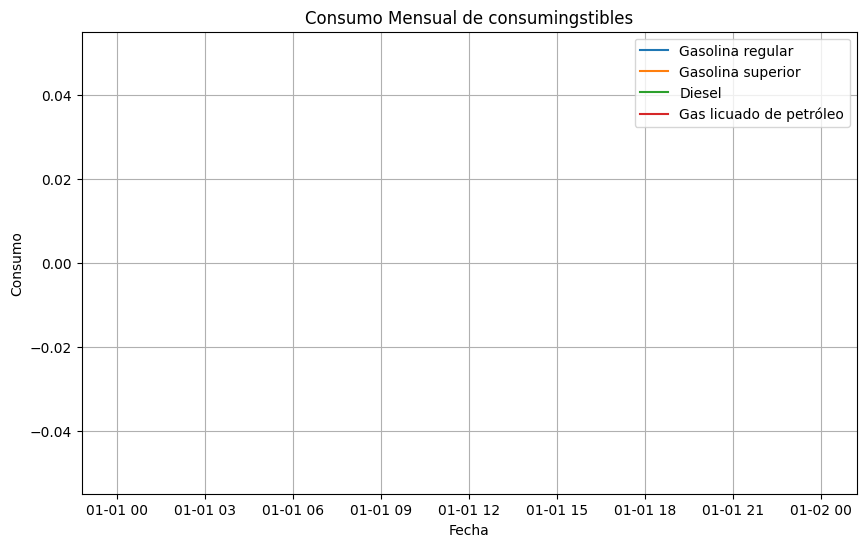

In [46]:
# Supongamos que 'consuming' es tu DataFrame y 'gas' es la lista de columnas de interés
gas = ['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']

# Asegurarse de que las columnas sean de tipo 'object' (cadena de texto)
for column in gas:
    consuming[column] = consuming[column].astype(str)

# Eliminar cualquier carácter no numérico o espacios en blanco
for column in gas:
    consuming[column] = consuming[column].str.replace(',', '').str.strip()

# Convertir las columnas a float
for column in gas:
    consuming[column] = pd.to_numeric(consuming[column], errors='coerce')

# Diccionario para traducir los meses en español a inglés
meses_espanol = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
    'jul': 'Jul', 'ago': 'Aug', 'sep': 'Sep', 'sept': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

# Función para traducir las fechas
def traducir_fecha(fecha):
    if isinstance(fecha, str):
        for mes_es, mes_en in meses_espanol.items():
            fecha = fecha.replace(mes_es, mes_en)
    return fecha

# Asegurarse de que el índice sea de tipo 'object' (cadena de texto)
consuming.index = consuming.index.astype(str)

# Traducir las fechas en el índice
consuming.index = consuming.index.map(traducir_fecha)

# Asegurarse de que el índice sea de tipo datetime con el formato correcto
if not pd.api.types.is_datetime64_any_dtype(consuming.index):
    consuming.index = pd.to_datetime(consuming.index, format='%b/%Y', errors='coerce')

# Filtrar las series de interés
consumo = consuming[gas]

print('\nConsumo Mensual:')
print(consumo.head())

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
for column in gas:
    plt.plot(consumo.index, consumo[column], label=column)

plt.title('Consumo Mensual de consumingstibles')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

### Serie de tiempo 2 lab anterior


Consumo Mensual:
       Gasolina regular  Gasolina superior  Diesel  Gas licuado de petróleo
Fecha                                                                      
NaT           177.77650          373.96396     0.0                194.06574
NaT           123.11599          243.09107     0.0                170.70338
NaT           161.72642          312.08438     0.0                161.83737
NaT           127.33874          285.05489     0.0                163.04864
NaT           168.73019          300.91367     0.0                171.51886


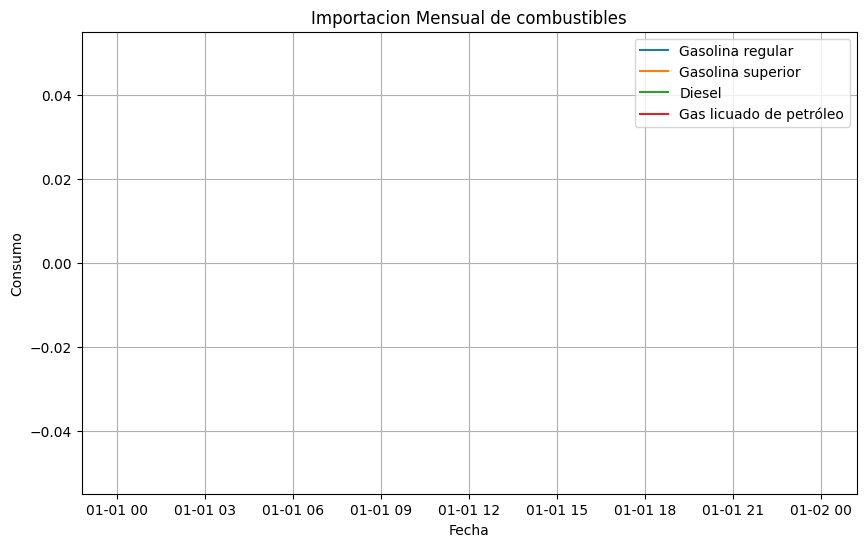

In [47]:
# Supongamos que 'importation' es tu DataFrame y 'gas' es la lista de columnas de interés
gas = ['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']

# Asegurarse de que las columnas sean de tipo 'object' (cadena de texto)
for column in gas:
    importation[column] = importation[column].astype(str)

# Eliminar cualquier carácter no numérico o espacios en blanco
for column in gas:
    importation[column] = importation[column].str.replace(',', '').str.strip()

# Convertir las columnas a float
for column in gas:
    importation[column] = pd.to_numeric(importation[column], errors='coerce')

# Diccionario para traducir los meses en español a inglés
meses_espanol = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
    'jul': 'Jul', 'ago': 'Aug', 'sep': 'Sep', 'sept': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

# Función para traducir las fechas
def traducir_fecha(fecha):
    if isinstance(fecha, str):
        for mes_es, mes_en in meses_espanol.items():
            fecha = fecha.replace(mes_es, mes_en)
    return fecha

# Asegurarse de que el índice sea de tipo 'object' (cadena de texto)
importation.index = importation.index.astype(str)

# Traducir las fechas en el índice
importation.index = importation.index.map(traducir_fecha)

# Asegurarse de que el índice sea de tipo datetime con el formato correcto
if not pd.api.types.is_datetime64_any_dtype(importation.index):
    importation.index = pd.to_datetime(importation.index, format='%b/%Y', errors='coerce')

# Filtrar las series de interés
importacion = importation[gas]

print('\nConsumo Mensual:')
print(importacion.head())

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
for column in gas:
    plt.plot(importacion.index, importacion[column], label=column)

plt.title('Importacion Mensual de combustibles')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

### Serie de tiempo 3 lab anterior

In [48]:
# function for clean data and append the type of gas & service

def clean_data(data, service, gas_type):
    # delete unnamed columns
    for column in data.columns:
        if 'Unnamed' in column:
            del data[column]

    # concat the service column
    data['service'] = service
    # concat gas type
    data['type'] = gas_type

    return data

# super gas prices for complete service
super_complete_service_prices = pd.read_csv('data/super_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_complete_service_prices = clean_data(super_complete_service_prices, 'Complete service', 'Super')

# super additive gas for self service
super_additive_complete_service_prices = pd.read_csv('data/super_additive_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_additive_complete_service_prices = clean_data(super_additive_complete_service_prices, 'Complete service', 'Super additive')

# regular gas for complete service
regular_complete_service_prices = pd.read_csv('data/regular_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
regular_complete_service_prices = clean_data(regular_complete_service_prices, 'Complete service', 'Regular')

# diesel gas for complete service
diesel_complete_service_prices = pd.read_csv('data/diesel_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
diesel_complete_service_prices = clean_data(diesel_complete_service_prices, 'Complete service', 'Diesel')

# super gas for self service
super_self_service_prices = pd.read_csv('data/super_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_self_service_prices = clean_data(super_self_service_prices, 'Self service', 'Super')

# super additive gas for self service
super_additive_self_service_prices = pd.read_csv('data/super_additive_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_additive_self_service_prices = clean_data(super_additive_self_service_prices, 'Self service', 'Super additive')

# regular gas for self service
regular_self_service_prices = pd.read_csv('data/regular_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
regular_self_service_prices = clean_data(regular_self_service_prices, 'Self service', 'Regular')

# diesel gas for self service
diesel_self_service_prices = pd.read_csv('data/diesel_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
diesel_self_service_prices = clean_data(diesel_self_service_prices, 'Self service', 'Diesel')

# concat all data
gas_prices = pd.concat([
    super_complete_service_prices,
    super_additive_complete_service_prices,
    regular_complete_service_prices,
    diesel_complete_service_prices,
    super_self_service_prices,
    super_additive_self_service_prices,
    regular_self_service_prices,
    diesel_self_service_prices
])

# Reset index to get MES/AÑO as a column
gas_prices.reset_index(inplace=True)

# Convert the data to long format
long_df = pd.melt(
    gas_prices,
    id_vars=['MES/AÑO', 'service', 'type'], 
    var_name='Year',
    value_name='Price'
)

# Convert 'Price' to numeric (replace commas and convert to float)
long_df['Price'] = long_df['Price'].str.replace(',', '.').astype(float)

gas_prices.head()


,MES/AÑO,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2017,2018,2019,2020,2021,2022,2023,2024,service,type
0,ENERO,"12,94","15,80","16,24","19,09","22,65","22,99","28,89","21,58","28,36",...,"24,69","25,83","23,03","25,60","23,82","31,41","35,12","31,59",Complete service,Super
1,FEBRERO,"12,76","16,64","17,49","18,60","22,35","22,04","28,71","21,35","27,99",...,"23,88","25,78","23,87","24,51","25,53","33,84","35,03","32,79",Complete service,Super
2,MARZO,"13,04","17,79","18,11","19,76","22,16","23,13","30,04","21,05","29,39",...,"23,42","25,80","25,80","23,60","27,70","39,12","34,40","34,92",Complete service,Super
3,ABRIL,"14,60","17,01","18,48","21,94","24,48","25,53","31,69","21,57","30,56",...,"24,20","27,10","27,82","18,97","28,03","38,83","36,33","36,21",Complete service,Super
4,MAYO,"14,65","15,92","18,89","22,48","26,85","27,59","33,12","22,81","29,84",...,"23,64","28,29","27,88","18,74","28,80","42,14","34,90","34,44",Complete service,Super


In [49]:
#analysis = ProfileReport(long_df)
#analysis.to_file('gas_prices_analysis.html')

In [50]:
gas_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MES/AÑO  104 non-null    object
 1   2002     100 non-null    object
 2   2003     104 non-null    object
 3   2004     104 non-null    object
 4   2005     104 non-null    object
 5   2006     104 non-null    object
 6   2007     104 non-null    object
 7   2008     104 non-null    object
 8   2009     104 non-null    object
 9   2010     104 non-null    object
 10  2011     104 non-null    object
 11  2012     104 non-null    object
 12  2013     104 non-null    object
 13  2014     104 non-null    object
 14  2015     104 non-null    object
 15  2016     104 non-null    object
 16  2017     104 non-null    object
 17  2018     104 non-null    object
 18  2019     104 non-null    object
 19  2020     104 non-null    object
 20  2021     104 non-null    object
 21  2022     104 non-null    object
 22  20

In [51]:
gas_prices.describe()

,MES/AÑO,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2017,2018,2019,2020,2021,2022,2023,2024,service,type
count,104,100,104,104,104,104,104,104,104,104,...,104,104,104,104,104,104,104,48,104,104
unique,13,93,93,96,99,102,101,103,97,101,...,95,98,94,94,101,98,99,47,2,4
top,ENERO,"14,29","15,80","18,42","22,23","26,77","28,41","29,55","20,67","24,42",...,"23,19","27,06","21,94","22,76","28,03","35,28","34,10","34,92",Complete service,Super
freq,8,2,4,2,3,2,2,2,2,2,...,2,2,2,3,2,3,2,2,52,26


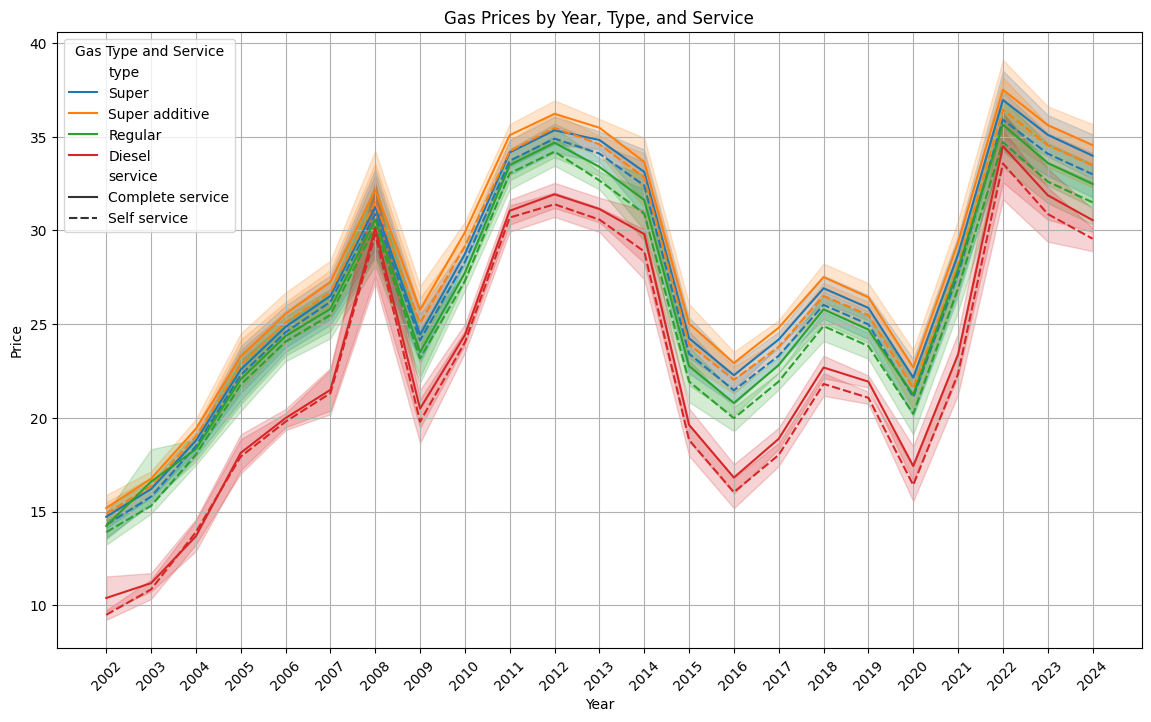

In [52]:
# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=long_df, x='Year', y='Price', hue='type', style='service')

plt.title('Gas Prices by Year, Type, and Service')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend(title='Gas Type and Service')
plt.grid(True)

plt.show()

1. Utilice los conjuntos de entrenamiento y prueba de una de las series que utilizó en el Laboratorio

In [53]:
# Utilizaremos la serie de ejemplo 1 'consumo' para obtener los datos de entrenamiento y prueba
# consumo' está correctamente cargado en el DataFrame

# Seleccionar las columnas de interés
data = consumo[['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']]

# Dividir en conjuntos de entrenamiento y prueba como el laboratorio anterior
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Sustituir valores NaN en la columna 'Diesel' por 0 en el conjunto de prueba
test_data['Diesel'] = test_data['Diesel'].fillna(0)

print("Datos de entrenamiento:")
print(train_data.head())
print("\nDatos de prueba:")
print(test_data.head())

Datos de entrenamiento:
       Gasolina regular  Gasolina superior  Diesel  Gas licuado de petróleo
Fecha                                                                      
NaT           202.64520          308.15682     0.0                194.41048
NaT           205.53096          307.76631     0.0                174.71055
NaT           229.49956          331.91029     0.0                189.23407
NaT           210.68040          315.64808     0.0                174.33061
NaT           208.16434          319.66797     0.0                191.74515

Datos de prueba:
       Gasolina regular  Gasolina superior  Diesel  Gas licuado de petróleo
Fecha                                                                      
NaT           650.15078          615.55933     0.0                419.95802
NaT           668.78339          632.41570     0.0                419.49382
NaT           616.07930          587.86184     0.0                396.86064
NaT           669.00877          643.04433    

2. Haga al menos 2 modelos con configuraciones diferentes usando LSTM por cada serie de las que utilizó. Haga un tuneo de parámetros de los modelos.

### Serie 1 consumos


Columna: Gasolina regular
Epoch 1/20


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0796 - val_loss: 0.1921
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0126 - val_loss: 0.0117
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0105 - val_loss: 0.0683
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0067 - val_loss: 0.0263
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0036 - val_loss: 0.0222
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0033 - val_loss: 0.0110
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030 - val_loss: 0.0108
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - val_loss: 0.0167
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024 - val_loss: 0.0110
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0023 - val_loss: 0.0105
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024 - val_loss: 0.0106
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0026 - val_loss: 0.0105
Epoch 13/20


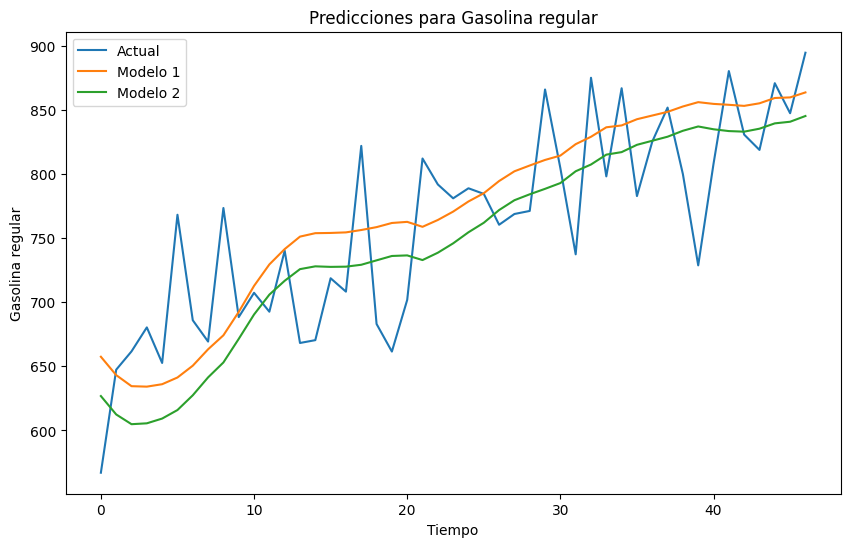


Columna: Gasolina superior
Epoch 1/20


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.1806 - val_loss: 0.2651
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0284 - val_loss: 0.0486
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0280 - val_loss: 0.0663
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0129 - val_loss: 0.0930
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0140 - val_loss: 0.0463
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0087 - val_loss: 0.0428
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0073 - val_loss: 0.0476
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0074 - val_loss: 0.0454
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0069 - val_loss: 0.0468
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0070 - val_loss: 0.0458
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0076 - val_loss: 0.0456
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0084 - val_loss: 0.0452
Epoch 13/20

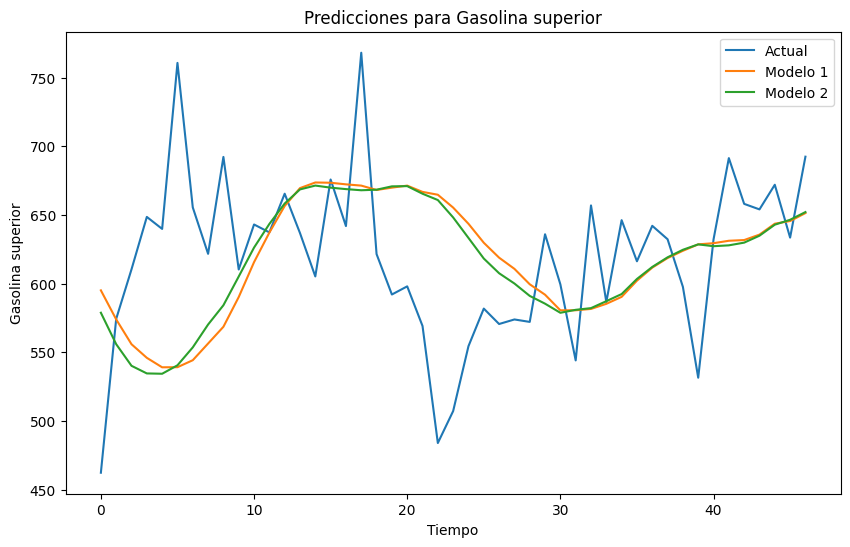


Columna: Diesel
Epoch 1/20


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: nan - val_loss: nan
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: nan - val_loss: nan
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: nan - val_loss: nan
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: nan - val_loss: nan
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: nan - val_loss: nan
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: nan - val_loss: nan
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: nan - val_loss: nan
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: nan - val_loss: nan
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: nan - val_loss: nan
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: nan - val_loss: nan
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: nan - val_loss: nan
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: nan - val_loss: nan
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: nan - val_loss: nan
Epoch 

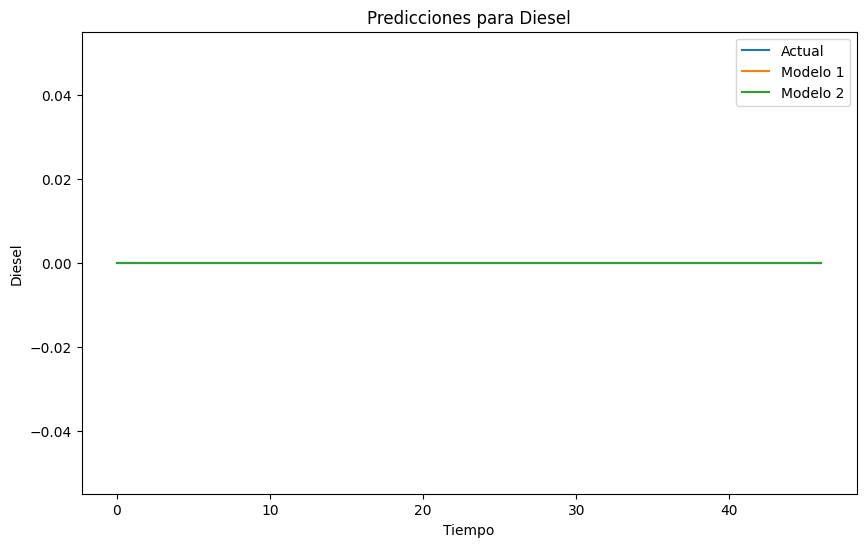


Columna: Gas licuado de petróleo
Epoch 1/20


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.1855 - val_loss: 0.4924
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0282 - val_loss: 0.0214
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0260 - val_loss: 0.0672
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0099 - val_loss: 0.1379
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0103 - val_loss: 0.0257
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0070 - val_loss: 0.0093
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0046 - val_loss: 0.0218
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0048 - val_loss: 0.0107
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0033 - val_loss: 0.0140
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0044 - val_loss: 0.0104
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0039 - val_loss: 0.0111
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0032 - val_loss: 0.0101
Epoch 13/20

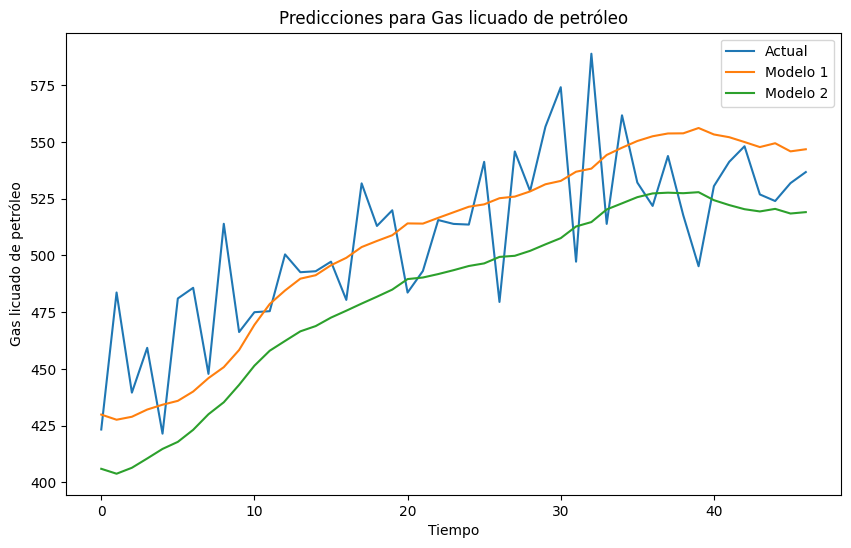

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

def prepare_data(train_data, test_data, seq_length):
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train = create_sequences(train_data_scaled, seq_length)
    y_train = train_data_scaled[seq_length:]
    X_test = create_sequences(test_data_scaled, seq_length)
    y_test = test_data_scaled[seq_length:]

    return X_train, y_train, X_test, y_test, scaler

SEQ_LENGTH = 12

# Preparar los datos para cada columna
for column in data.columns:
    print(f"\nColumna: {column}")

    train_series = train_data[[column]]
    test_series = test_data[[column]]

    X_train, y_train, X_test, y_test, scaler = prepare_data(train_series, test_series, SEQ_LENGTH)

    # Modelo 1: Configuración básica
    model1 = Sequential([
        LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    model1.compile(optimizer='adam', loss='mse')
    model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Modelo 2: Configuración con Dropout y más unidades LSTM
    model2 = Sequential([
        LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model2.compile(optimizer='adam', loss='mse')
    model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluar y comparar los modelos
    predictions1 = model1.predict(X_test)
    predictions2 = model2.predict(X_test)

    # Desescalar las predicciones
    predictions1 = scaler.inverse_transform(predictions1)
    predictions2 = scaler.inverse_transform(predictions2)
    y_test_descaled = scaler.inverse_transform(y_test)

    # Asegurarse de que no haya NaN en las predicciones
    predictions1 = np.nan_to_num(predictions1)
    predictions2 = np.nan_to_num(predictions2)
    y_test_descaled = np.nan_to_num(y_test_descaled)

    mse1 = mean_squared_error(y_test_descaled, predictions1)
    mse2 = mean_squared_error(y_test_descaled, predictions2)

    print(f"MSE del Modelo 1 para {column}: {mse1}")
    print(f"MSE del Modelo 2 para {column}: {mse2}")

    # Graficar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_descaled, label='Actual')
    plt.plot(predictions1, label='Modelo 1')
    plt.plot(predictions2, label='Modelo 2')
    plt.title(f'Predicciones para {column}')
    plt.xlabel('Tiempo')
    plt.ylabel(column)
    plt.legend()
    plt.show()

### Serie 2 Importacion


Columna: Gasolina regular
Epoch 1/20


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0896 - val_loss: 0.1534
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0211 - val_loss: 0.0142
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0202 - val_loss: 0.0603
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0130 - val_loss: 0.0660
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0141 - val_loss: 0.0154
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0124 - val_loss: 0.0143
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0100 - val_loss: 0.0172
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0111 - val_loss: 0.0155
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0110 - val_loss: 0.0191
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0096 - val_loss: 0.0156
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0107 - val_loss: 0.0199
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0108 - val_loss: 0.0196
Epoch 13/20

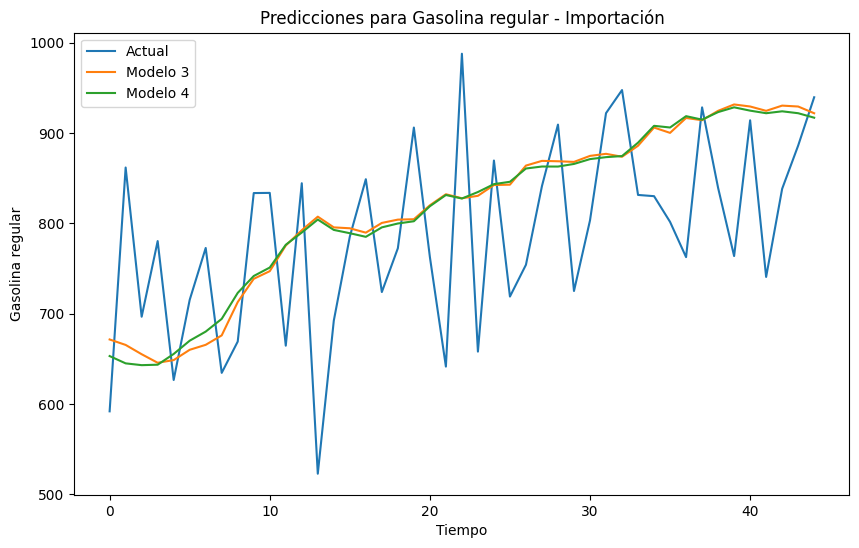


Columna: Gasolina superior
Epoch 1/20


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.2449 - val_loss: nan
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0487 - val_loss: nan
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0433 - val_loss: nan
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0283 - val_loss: nan
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0318 - val_loss: nan
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0270 - val_loss: nan
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0278 - val_loss: nan
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0275 - val_loss: nan
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0294 - val_loss: nan
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0265 - val_loss: nan
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0251 - val_loss: nan
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0253 - val_loss: nan
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/st

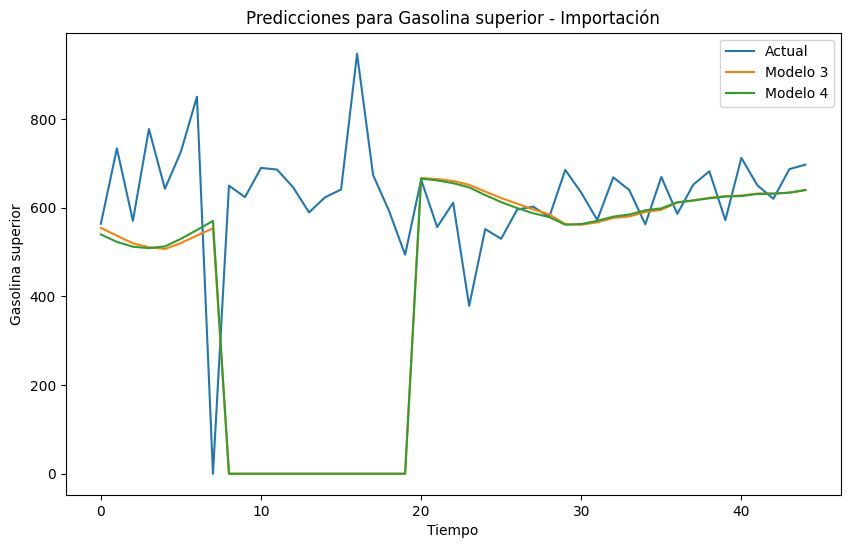


Columna: Diesel
Epoch 1/20


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: nan - val_loss: nan
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: nan - val_loss: nan
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: nan - val_loss: nan
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: nan - val_loss: nan
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: nan - val_loss: nan
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: nan - val_loss: nan
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: nan - val_loss: nan
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: nan - val_loss: nan
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: nan - val_loss: nan
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: nan - val_loss: nan
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: nan - val_loss: nan
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: nan - val_loss: nan
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: nan - val_loss: nan
Epoch

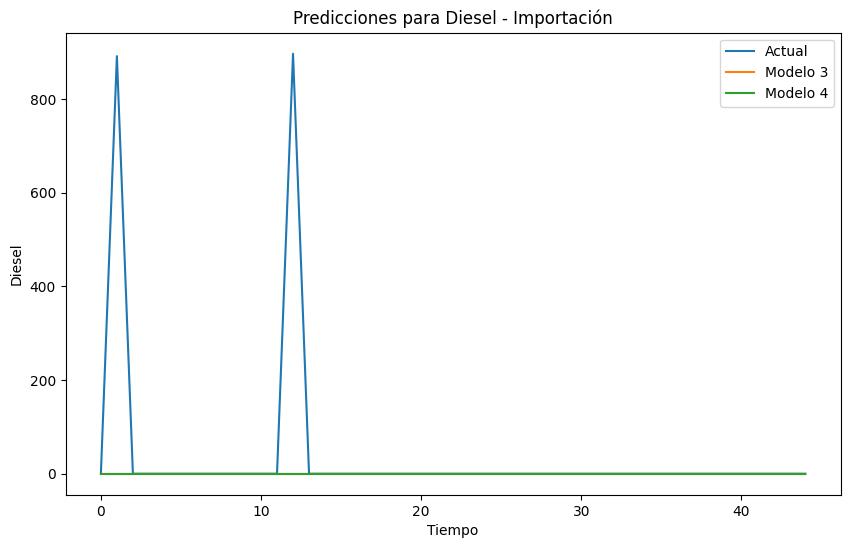


Columna: Gas licuado de petróleo
Epoch 1/20


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 0.0984 - val_loss: nan
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0234 - val_loss: nan
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0266 - val_loss: nan
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0239 - val_loss: nan
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0220 - val_loss: nan
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0245 - val_loss: nan
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0251 - val_loss: nan
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0216 - val_loss: nan
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0216 - val_loss: nan
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0224 - val_loss: nan
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0206 - val_loss: nan
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0225 - val_loss: nan
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/st

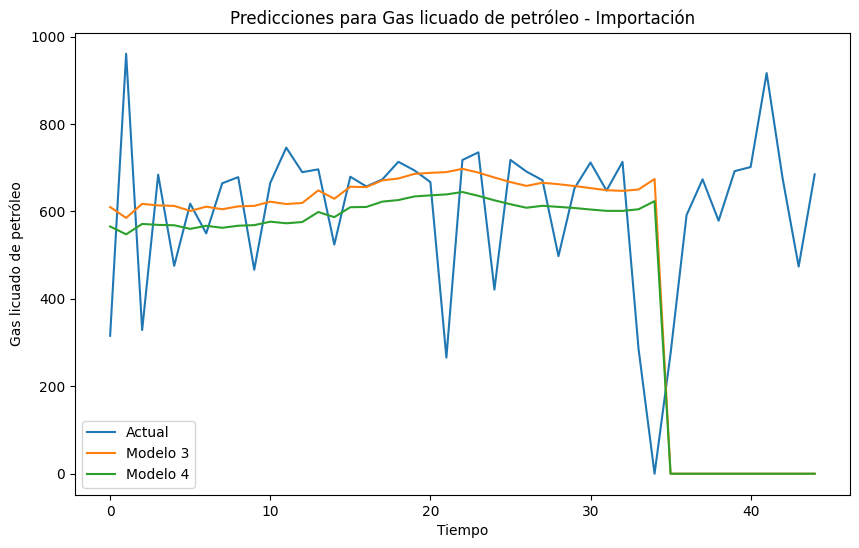

In [55]:
# Seleccionar las columnas de interés
data_importacion = importacion[['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']]

# Dividir en conjuntos de entrenamiento y prueba
train_data_import, test_data_import = train_test_split(data_importacion, test_size=0.2, shuffle=False)

for column in data_importacion.columns:
    print(f"\nColumna: {column}")

    train_series_import = train_data_import[[column]]
    test_series_import = test_data_import[[column]]

    X_train_import, y_train_import, X_test_import, y_test_import, scaler_import = prepare_data(train_series_import, test_series_import, SEQ_LENGTH)

    # Modelo 3: Configuración básica
    model3 = Sequential([
        LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    model3.compile(optimizer='adam', loss='mse')
    model3.fit(X_train_import, y_train_import, epochs=20, batch_size=32, validation_data=(X_test_import, y_test_import))

    # Modelo 4: Configuración con Dropout y más unidades LSTM
    model4 = Sequential([
        LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model4.compile(optimizer='adam', loss='mse')
    model4.fit(X_train_import, y_train_import, epochs=20, batch_size=32, validation_data=(X_test_import, y_test_import))

    # Evaluar y comparar los modelos
    predictions3 = model3.predict(X_test_import)
    predictions4 = model4.predict(X_test_import)

    # Desescalar las predicciones
    predictions3 = scaler_import.inverse_transform(predictions3)
    predictions4 = scaler_import.inverse_transform(predictions4)
    y_test_import_descaled = scaler_import.inverse_transform(y_test_import)

    # Asegurarse de que no haya NaN en las predicciones
    predictions3 = np.nan_to_num(predictions3)
    predictions4 = np.nan_to_num(predictions4)
    y_test_import_descaled = np.nan_to_num(y_test_import_descaled)

    mse3 = mean_squared_error(y_test_import_descaled, predictions3)
    mse4 = mean_squared_error(y_test_import_descaled, predictions4)

    print(f"MSE del Modelo 3 para {column}: {mse3}")
    print(f"MSE del Modelo 4 para {column}: {mse4}")

    # Graficar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_import_descaled, label='Actual')
    plt.plot(predictions3, label='Modelo 3')
    plt.plot(predictions4, label='Modelo 4')
    plt.title(f'Predicciones para {column} - Importación')
    plt.xlabel('Tiempo')
    plt.ylabel(column)
    plt.legend()
    plt.show()

### Serie 3 Precios